# Data analysis of Zenodo zip content

This [Jupyter Notebook](https://jupyter.org/) explores the data retrieved by [data-gathering](../data-gathering) workflows.

It assumes the `../../data` directory has been populated by the [Snakemake](https://snakemake.readthedocs.io/en/stable/) workflow [zenodo-random-samples-zip-content](data-gathering/workflows/zenodo-random-samples-zip-content/). To regenerate `data` run `make` in the root directory of this repository.

In [14]:
!pwd

/home/stain/ro-index-paper/code/analysis


For convenience, the `data` symlink points to `../../data`.

In [15]:
!ls data

dataset  others  seed  software  zenodo-records  zenodo.org


This notebook analyse the zenodo records sampled using this random seed:

In [16]:
!sha512sum data/seed

a381bd4152d69342661bba7cb00c34561bdfe69930a00a39973851076fc0ae4b8850df817adc8cad31481004ddeb3eaa080d61ed9dab280be80808b9da2cb97e  data/seed


## Zenodo metadata

The starting point of this analysis is the Zenodo metadata dump <https://doi.org/10.5281/zenodo.3531504>. This contains the metadata of 3.5 million Zenodo records in the [Zenodo REST API](https://developers.zenodo.org/)'s internal JSON format. 

Each Zenodo record, for instance <https://zenodo.org/record/14614> consists of metadata <https://zenodo.org/api/records/14614> which links to one or more downloadable files like <https://zenodo.org/api/files/866253b6-e4f2-4a06-96fa-618ff76438e6/powertac_2014_04_qualifying_21-30.zip>. 

Below we explore Zenodo record `14614` to highlight which part of the metadata we need to inspect.

In [17]:
import requests
rec = requests.get("https://zenodo.org/api/records/14614").json()
rec

{'conceptrecid': '607830',
 'created': '2015-01-27T16:15:18+00:00',
 'doi': '10.5281/zenodo.14614',
 'files': [{'bucket': '866253b6-e4f2-4a06-96fa-618ff76438e6',
   'checksum': 'md5:bf8069e726b37dce93593cf377a86a61',
   'key': 'powertac_2014_04_qualifying_21-30.zip',
   'links': {'self': 'https://zenodo.org/api/files/866253b6-e4f2-4a06-96fa-618ff76438e6/powertac_2014_04_qualifying_21-30.zip'},
   'size': 799012573,
   'type': 'zip'}],
 'id': 14614,
 'links': {'badge': 'https://zenodo.org/badge/doi/10.5281/zenodo.14614.svg',
  'bucket': 'https://zenodo.org/api/files/866253b6-e4f2-4a06-96fa-618ff76438e6',
  'doi': 'https://doi.org/10.5281/zenodo.14614',
  'html': 'https://zenodo.org/record/14614',
  'latest': 'https://zenodo.org/api/records/14614',
  'latest_html': 'https://zenodo.org/record/14614',
  'self': 'https://zenodo.org/api/records/14614'},
 'metadata': {'access_right': 'open',
  'access_right_category': 'success',
  'communities': [{'id': 'powertac'}],
  'creators': [{'name': '

In [18]:
rec["files"][0]["type"] # File extension

'zip'

In [19]:
rec["files"][0]["links"]["self"] # Download link

'https://zenodo.org/api/files/866253b6-e4f2-4a06-96fa-618ff76438e6/powertac_2014_04_qualifying_21-30.zip'

In [20]:
rec["metadata"]["access_right"] # "open" means we are allowed to download the above

'open'

In [21]:
rec["links"]["doi"] # DOI for citing this Zenodo record

'https://doi.org/10.5281/zenodo.14614'

In [22]:
rec["metadata"]["resource_type"]["type"]   # DateCite resource type; "software", "dataset", etc.

'dataset'

The preliminary workflow that produced the Zenodo dump retrieved the 3.5M JSON files and concatinated them into a single JSONseq format [RFC7464](https://tools.ietf.org/html/rfc7464) to be more easily processed with tools like [jq](https://stedolan.github.io/jq/).

As this particular analysis explores the content of deposited **ZIP archives**, an important step of the archive content workflow is to select only the Zenodo records that deposits `*.zip` files, by filtering the metadata fields shown above `rec["metadata"]["access_right"] == "open"` and `rec["files"][*]["type"] == "zip"`.

Before we explore this, let's have a quick look at what file extensions are most commonly deposited at Zenodo.

### Zenodo deposits by file extension

Below use [jq](https://stedolan.github.io/jq/) from the compressed jsonseq to select all downloadable files from Zenodo, expressed as a TSV file. 

In [23]:
!xzcat data/zenodo.org/record/3531504/files/zenodo-records-json-2019-09-16-filtered.jsonseq.xz |\
 jq -r '. | select(.metadata.access_right == "open") | .metadata.resource_type.type as $rectype | . as $rec | ( .files[]?  ) | [$rec.id, $rec.links.self, $rec.links.doi, .checksum, .links.self, .size, .type, .key, $rectype] | @tsv' |\
 gzip > data/zenodo-records/files.tsv.gz 

The table contains one line per download; note that some records have multiple downloads. 

Parse the TSV file with the Python Data Analysis Library [pandas](https://pandas.pydata.org/):

In [24]:
import pandas as pd
header = ["record_id", "record_json", "record_doi", "file_checksum", "file_download", "file_size", "file_extension", "file_name", "record_type"]
files = pd.read_table("data/zenodo-records/files.tsv.gz", compression="gzip", header=None, names=header)
files

,record_id,record_json,record_doi,file_checksum,file_download,file_size,file_extension,file_name,record_type
0,788,https://zenodo.org/api/records/788,https://doi.org/10.1016/j.pocean.2009.09.002,md5:705ebd78f09b797130ecb0d9b610ae84,https://zenodo.org/api/files/22ae1d25-576e-490...,52113,pdf,hofmann FINAL.pdf,publication
1,791,https://zenodo.org/api/records/791,https://doi.org/10.1016/j.pocean.2009.09.013,md5:badd06ded9bc0ac4070835213920dcbc,https://zenodo.org/api/files/dc682e6a-5695-4f0...,301315,pdf,Maury FINAL.pdf,publication
2,804,https://zenodo.org/api/records/804,https://doi.org/10.1371/journal.pone.0011832,md5:a4e3ca94d4b5ca45c25a1d7e5c650939,https://zenodo.org/api/files/60a9aabd-8358-44e...,1534942,pdf,Danovaro et al 2010 PLOSone.pdf,publication
3,812,https://zenodo.org/api/records/812,https://doi.org/10.1016/j.tibtech.2010.10.001,md5:95fbb0bfce796efaeb223cffa33b1a6d,https://zenodo.org/api/files/b1cbaf58-01a2-4d0...,399492,pdf,Strik postprint TIB.pdf,publication
4,847,https://zenodo.org/api/records/847,https://doi.org/10.1016/j.mee.2011.04.069,md5:355e490cd910b55a44fdb43912cfe8d8,https://zenodo.org/api/files/b82d2a8d-c02b-4eb...,217919,pdf,LightModulationinPhoxonicNanocavities_Papaniko...,publication
...,...,...,...,...,...,...,...,...,...
2203084,3024270,https://zenodo.org/api/records/3024270,https://doi.org/10.5281/zenodo.3024270,md5:094c1a969f2d300ffd1c020329f97147,https://zenodo.org/api/files/b42ec8b0-1231-4c5...,2859031,jpg,BR0000012538638.jpg,image
2203085,3024600,https://zenodo.org/api/records/3024600,https://doi.org/10.5281/zenodo.3024600,md5:00fded7946f15953f1a04c7b33f01a9b,https://zenodo.org/api/files/ecf6f418-5e2e-443...,2575973,jpg,BR0000011583820.jpg,image
2203086,3025124,https://zenodo.org/api/records/3025124,https://doi.org/10.5281/zenodo.3025124,md5:0ed56a6a68b536f2284fe9e19d80dcf9,https://zenodo.org/api/files/693d15b2-5cde-457...,3276819,jpg,BR0000011585800.jpg,image
2203087,3025298,https://zenodo.org/api/records/3025298,https://doi.org/10.5281/zenodo.3025298,md5:f68716ac78690c3d636736660de9a8dd,https://zenodo.org/api/files/85a29013-440d-4f8...,4522707,jpg,BR0000011586258.jpg,image


From this we can select the number of downloadable files per file extension, here the top 30:

In [25]:
extensions = files.groupby("file_extension")["file_download"].nunique().sort_values(ascending=False)
extensions.head(30)

file_extension
pdf            764821
jpg            506230
h5             177683
png            174906
zip            124751
txt             59036
gz              33910
tif             32472
hdf5            30671
json            27138
bz2             19976
csv             16895
wav             14804
xml             12746
mat             11898
cbf             11412
tgz             10518
wmv              9523
docx             9158
nc               9094
perl             8536
dcm              6776
dat              6491
xlsx             6278
fits             6233
cr2              4742
out              4394
xls              4029
mp4              2923
0parameters      2220
Name: file_download, dtype: int64

Note that as some records contain multiple downloads, so if instead we count number of records containing a particular file extension, the list changes somewhat:

In [26]:
extensions = files.groupby("file_extension")["record_id"].nunique().sort_values(ascending=False)
extensions.head(30)

file_extension
pdf     754024
jpg     337958
png     160450
zip      86788
hdf5     15061
txt      11517
json     10838
xml      10388
tgz       8917
h5        8777
perl      8536
docx      8141
gz        5466
xlsx      3497
csv       2779
tif       2401
out       1590
pptx      1573
md        1515
meta      1191
doc       1103
mp4       1022
xls        840
svg        679
dat        590
rar        499
r          497
py         462
tar        461
mat        444
Name: record_id, dtype: int64

Perhaps not unsurprisingly, the document format `*.pdf` is highest in both cases, followed by several image formats like `*.jpg`, `*.png`,  and `*.tif`. 

Let's see grouping by `record_type` affects the file extensions:

In [27]:
files.groupby(["record_type","file_extension"])["record_id"] \
     .nunique().sort_values(ascending=False).head(30)

record_type   file_extension
publication   pdf               736905
image         jpg               336754
              png               159609
software      zip                62288
dataset       zip                22321
              hdf5               15054
              txt                10758
publication   xml                 9851
dataset       tgz                 8798
              h5                  8757
              json                8715
              perl                8536
presentation  pdf                 7975
publication   docx                6633
dataset       gz                  3845
poster        pdf                 3697
dataset       xlsx                2780
              pdf                 2741
              csv                 2389
image         json                1804
              tif                 1636
dataset       out                 1578
other         pdf                 1410
presentation  pptx                1282
software      gz                  1

As we might have suspected, `*.pdf` deposits of type `publication` are most common, as Zenodo is frequently used for depositing preprints.  

In this research we are looking at archive-like deposits to inspect for structured metadata. It is clear that a large set of deposits above of type `dataset` should be our primary concern, keeping in mind other types, like we notice `*.meta` on `publication` records.

A suspicion is that a large set of `*.zip` deposits of record type `software` are made by [Zenodo-GitHub integration](https://guides.github.com/activities/citable-code/) of software source code archives, which we should treat separate as any structured metadata there probably is related to compilation or software packaging. However, it is possible that some datasets are maintained in GitHub repositories and use this integration for automatic dataset DOI registration, although with a misleading record type.

Let's look at the file types used by records of type `dataset`:

In [28]:
files[files.record_type == "dataset"].groupby("file_extension")["record_id"] \
  .nunique().sort_values(ascending=False).head(30)

file_extension
zip     22321
hdf5    15054
txt     10758
tgz      8798
h5       8757
json     8715
perl     8536
gz       3845
xlsx     2780
pdf      2741
csv      2389
out      1578
docx     1145
xls       693
tif       615
dat       525
jpg       466
xml       459
png       433
mat       379
sav       366
tar       339
tpr       338
nc4       331
xtc       329
nc        325
rar       321
gro       316
top       307
kml       286
Name: record_id, dtype: int64

We notice that the combination of `*.h5` and `*.hdf5` for the [Hierarchical Data Format](https://www.hdfgroup.org/) overtakes `*.zip` as the most popular file extension; this format can be considered a hybrid of _archive_, _structured_ and _semi-structured data_; as the format supports multiple data entries and metadata, but suspected typical use of the format is a dump of multi-dimensional integers and floating point numbers with no further metadata.

### Brief categorization of top 30 Zenodo Dataset file extensions

* Archive/combined: zip, hdf5, h5, tgz, tar
* Compressed: gz
* Structured data: json, xml
* Semi-structured data: xlsx, csv, xls
* Unstructured/proprietary: txt, dat, mat (matlab)
* Textual/document: pdf, docx
* Image: tif, jpg, png
* Source code: perl
* Save games for emulators: sav
* Geodata/maps: kml 
* Molecular dynamics: gro (Gromacs)
* Log data?: out
* **TODO** (Unknown to author): tpr, nc4, xtc, nc, top
 
Setting aside HDF5 for later analysis, we find that archive-like formats is dominated by `*.zip` with 22,321 records, followed 12,982 records for the the combination `*.tgz`, `*.tar` and `*.gz` (which include both `*.tar.gz` archives and single file compressions like `*.txt.gz`).

The first analysis therefore examines these ZIP for their file listing, to find common filenames, aiming to repeat this for `tar`-based archives. As we see a large split between `dataset` and `software` records these are kept separate, with a third category for `*.zip` files of any other record type.

Number of `*.zip` downloads per record type:

In [29]:
files[files.file_extension == "zip"].groupby("record_type")["file_download"].count()

record_type
dataset         58384
image             243
lesson            390
other             620
poster             21
presentation      130
publication      1951
software        62799
video             213
Name: file_download, dtype: int64

A concern of downloading to inspect all the ZIP files of Zenodo is that they vary considerably in size:

In [30]:
files[files.file_extension == "zip"]["file_size"].describe()

count    1.247510e+05
mean     2.214071e+08
std      1.832143e+09
min      0.000000e+00
25%      5.728425e+05
50%      1.198928e+07
75%      1.110557e+08
max      1.986057e+11
Name: file_size, dtype: float64

In [31]:
total_download = files[files.file_extension == "zip"]["file_size"].sum() / 1024**4
total_download

25.120926916089957

In [32]:
files[files.file_extension == "zip"]["file_size"].count()

124751

We see that 50% of the 125k ZIP files are 11 MiB or less, the largest 25% are 106 MiB or more, and the largest file is 184 GiB. The smallest 25% of ZIP files are less than 559 kiB and would fit on a floppy. This wide spread helps explains the large standard deviation of 1.8 GiB.  Total download of all files is 25 TiB.

A binary logarithmic histogram (log2, 80 bins):

1181811     0.000000
1883205     4.459432
2036708     6.977280
2036702     7.000000
1543547     7.189825
             ...    
447864     36.385185
1118364    36.824644
139888     36.938645
591435     37.014096
263240     37.531116
Name: file_size, Length: 124751, dtype: float64

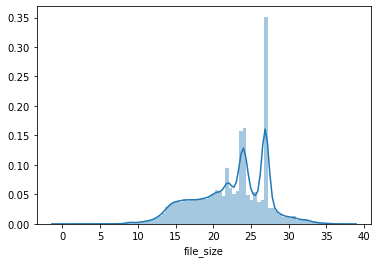

In [33]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
fig,ax = plt.subplots()
#ax.set(xscale="linear", yscale="linear")
filesizes = files[files.file_extension == "zip"]["file_size"]\
       .transform(np.log2).replace([np.inf, -np.inf], 0)       
sns.distplot(filesizes, bins=80, ax=ax)
filesizes.sort_values()

Notice the peculiar distribution with two peaks around 2^24 and 2^27 bytes downloads. It is possible that these are caused by multiple uploads of very similar-sized deposit, e.g. multiple versions from automatic data release systems, or more likely by the overlay of different file size distributions for different categories (dataset, software, publications). **TODO** Graph per category.

## Workflow: Listing ZIP content 

The workflow `code/data-gathering/workflows/zenodo-random-samples-zip-content` performs the second download task of sampling `*.zip` files to list their contained filenames. It works by a sample size per category, so that the analysis can be performed without downloading


### Workflow overview

The executed Snakemake workflow consists of rules that can be visualized using [Graphviz](https://www.graphviz.org/):


In [34]:
!cd ../data-gathering/workflows/zenodo-random-samples-zip-content ; \
 snakemake --rulegraph | dot -Tsvg > workflow.svg

Building DAG of jobs...


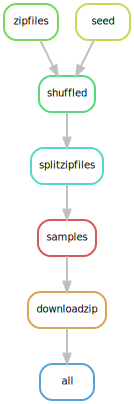

In [35]:
from IPython.core.display import SVG
SVG(filename='../data-gathering/workflows/zenodo-random-samples-zip-content/workflow.svg')

The first step **zipfiles** uses [jq](https://stedolan.github.io/jq/) to create TSV files as shown above, where the file extension is `*.zip`:

In [36]:
zipfiles = pd.read_table("data/zenodo-records/zipfiles.tsv", header=None, names=header)
zipfiles

,record_id,record_json,record_doi,file_checksum,file_download,file_size,file_extension,file_name,record_type
0,7096,https://zenodo.org/api/records/7096,https://doi.org/10.5281/zenodo.7096,md5:46b5c3aab7aa3fa58e5822c9c3dbd3a7,https://zenodo.org/api/files/1b8adb97-6ffc-4ae...,105878933,zip,cyrface_v1.0.zip,publication
1,1000116,https://zenodo.org/api/records/1000116,https://doi.org/10.5281/zenodo.1000116,md5:765d22dbe4241c67f3b6dbacf79fc901,https://zenodo.org/api/files/36ee07d5-7c07-438...,20233334,zip,s10.zip,dataset
2,1000116,https://zenodo.org/api/records/1000116,https://doi.org/10.5281/zenodo.1000116,md5:bb63c22179b4a750bac2499aecd72021,https://zenodo.org/api/files/36ee07d5-7c07-438...,19462713,zip,s1.zip,dataset
3,1000116,https://zenodo.org/api/records/1000116,https://doi.org/10.5281/zenodo.1000116,md5:9d91c5a524123e950cd7cab3b42887ae,https://zenodo.org/api/files/36ee07d5-7c07-438...,20435979,zip,s2.zip,dataset
4,1000116,https://zenodo.org/api/records/1000116,https://doi.org/10.5281/zenodo.1000116,md5:700d15737cd5219cf9e9a0370670f246,https://zenodo.org/api/files/36ee07d5-7c07-438...,22098551,zip,s3.zip,dataset
...,...,...,...,...,...,...,...,...,...
124746,2924309,https://zenodo.org/api/records/2924309,https://doi.org/10.5281/zenodo.2924309,md5:9a92c2a2d30e55563510fe2b9c095cf2,https://zenodo.org/api/files/a46d8084-6d3e-441...,2110162,zip,oso_tg_2015_182_to_2016_182.zip,dataset
124747,2483402,https://zenodo.org/api/records/2483402,https://doi.org/10.5281/zenodo.2483402,md5:4957f57293acab97034caa4c33b21dab,https://zenodo.org/api/files/b613706f-7ee2-4d9...,102194301,zip,Data.zip,dataset
124748,2525460,https://zenodo.org/api/records/2525460,https://doi.org/10.5281/zenodo.2525460,md5:3210020de6c56cc12a70de68f0b5528a,https://zenodo.org/api/files/06474150-e58f-412...,652482,zip,NorthernWidget-Skunkworks/Project-Tally-v0.1.zip,software
124749,2525534,https://zenodo.org/api/records/2525534,https://doi.org/10.5281/zenodo.2525534,md5:2760f5ef4d4f573893e4ec30104a6c6d,https://zenodo.org/api/files/7d610f61-a62f-45c...,66443,zip,r-barnes/Barnes2019-Landscape-v1.0.1.zip,software


The **shuffled** step does a random shuffle of the rows, but using the `seed` file as random data source for reproducibility (a new source will be recreated by **seed** if missing).

In [37]:
shuffled = pd.read_table("data/zenodo-records/zipfiles-shuffled.tsv", header=None, names=header)
shuffled

,record_id,record_json,record_doi,file_checksum,file_download,file_size,file_extension,file_name,record_type
0,3245891,https://zenodo.org/api/records/3245891,https://doi.org/10.5281/zenodo.3245891,md5:7ab1b77dbe36b089c4935f971c1d8709,https://zenodo.org/api/files/95f173d2-c1ab-49b...,165373381,zip,foehntjan8110.zip,dataset
1,3364804,https://zenodo.org/api/records/3364804,https://doi.org/10.5281/zenodo.3364804,md5:2e36797b3c1d9cf525736ca17a2e12ab,https://zenodo.org/api/files/d4a0dac4-9012-4f4...,6577603,zip,gnuradio/gnuradio-v3.8.0.0.zip,software
2,848081,https://zenodo.org/api/records/848081,https://doi.org/10.1145/2851141.2851148,md5:8b9963e6404cc026c381057c40962957,https://zenodo.org/api/files/7ff6c078-21d7-435...,19500731,zip,Exp.zip,publication
3,556985,https://zenodo.org/api/records/556985,https://doi.org/10.5281/zenodo.556985,md5:6e1c0df86d351a313eb94df32a1b7fc2,https://zenodo.org/api/files/2767ef6d-3bfd-434...,179393377,zip,OpenGreekAndLatin/First1KGreek-1.1.63.zip,software
4,806739,https://zenodo.org/api/records/806739,https://doi.org/10.5281/zenodo.806739,md5:df9758f35c03bc45de2fcd218b49d456,https://zenodo.org/api/files/601ddc8d-f338-429...,175858,zip,tabular-model-src.zip,software
...,...,...,...,...,...,...,...,...,...
124746,1027997,https://zenodo.org/api/records/1027997,https://doi.org/10.5281/zenodo.1027997,md5:9fafda2e266ca66d9b563ad1a5423110,https://zenodo.org/api/files/2102027f-53f0-4e9...,14601979,zip,egl-20 (mu39)IV on food L_2010_07_16__11_24___...,dataset
124747,45837,https://zenodo.org/api/records/45837,https://doi.org/10.5281/zenodo.45837,md5:4d9be07bc68eda5dde53ac67918700e6,https://zenodo.org/api/files/2b8f17b7-b711-447...,87444828,zip,TURNO2_DEB_RECORD_19102014.zip,dataset
124748,31742,https://zenodo.org/api/records/31742,https://doi.org/10.5281/zenodo.31742,md5:c4bbd596b956fb746a64cb65b58791b2,https://zenodo.org/api/files/f3c7751f-273c-477...,544611,zip,dispRity-v.0.1.zip,software
124749,2669187,https://zenodo.org/api/records/2669187,https://doi.org/10.5281/zenodo.2669187,md5:3d3221fc0cb50d86a52f0b1ead0a998e,https://zenodo.org/api/files/d1906547-b36f-45b...,125608779,zip,subject01_session06.zip,dataset


The shuffled file is then split into `zipfiles-dataset.tsv`, `zipfiles-software.tsv` and `zipfiles-others.tsv` (?) by **splitzipfiles**.

In [38]:
!ls data/zenodo-records

files-extensions.txt  zipfiles-dataset.tsv  zipfiles-shuffled.tsv  zipfiles.tsv
files.tsv.gz	      zipfiles-others.tsv   zipfiles-software.tsv


The step **samples** then picks the configured number of `MAXSAMPLES` (2000) from each of the category TSV files, which are split into individual files per row using [GNU Coreutils split](https://www.gnu.org/software/coreutils/manual/html_node/split-invocation.html). Note that the filenames are generated alphabetically by `split`, as the category TSV files are pre-shuffled this simply selects the first 2000 lines from each.

In [39]:
!ls data/dataset/sample | wc -l

5000


In [43]:
!ls -C data/dataset/sample | tail -n50

wd.tsv	zave.tsv  zbtf.tsv  zcrg.tsv  zdph.tsv	zeni.tsv  zflj.tsv  zgjk.tsv
we.tsv	zavf.tsv  zbtg.tsv  zcrh.tsv  zdpi.tsv	zenj.tsv  zflk.tsv  zgjl.tsv
wf.tsv	zavg.tsv  zbth.tsv  zcri.tsv  zdpj.tsv	zenk.tsv  zfll.tsv  zgjm.tsv
wg.tsv	zavh.tsv  zbti.tsv  zcrj.tsv  zdpk.tsv	zenl.tsv  zflm.tsv  zgjn.tsv
wh.tsv	zavi.tsv  zbtj.tsv  zcrk.tsv  zdpl.tsv	zenm.tsv  zfln.tsv  zgjo.tsv
wi.tsv	zavj.tsv  zbtk.tsv  zcrl.tsv  zdpm.tsv	zenn.tsv  zflo.tsv  zgjp.tsv
wj.tsv	zavk.tsv  zbtl.tsv  zcrm.tsv  zdpn.tsv	zeno.tsv  zflp.tsv  zgjq.tsv
wk.tsv	zavl.tsv  zbtm.tsv  zcrn.tsv  zdpo.tsv	zenp.tsv  zflq.tsv  zgjr.tsv
wl.tsv	zavm.tsv  zbtn.tsv  zcro.tsv  zdpp.tsv	zenq.tsv  zflr.tsv  zgjs.tsv
wm.tsv	zavn.tsv  zbto.tsv  zcrp.tsv  zdpq.tsv	zenr.tsv  zfls.tsv  zgjt.tsv
wn.tsv	zavo.tsv  zbtp.tsv  zcrq.tsv  zdpr.tsv	zens.tsv  zflt.tsv  zgju.tsv
wo.tsv	zavp.tsv  zbtq.tsv  zcrr.tsv  zdps.tsv	zent.tsv  zflu.tsv  zgjv.tsv
wp.tsv	zavq.tsv  zbtr.tsv  zcrs.tsv  zdpt.tsv	zenu.tsv  zflv.tsv  zgjw.tsv
wq.tsv	zavr.tsv  zbts.tsv

In [44]:
!cat data/dataset/sample/zapf.tsv

1971811	https://zenodo.org/api/records/1971811	https://doi.org/10.5281/zenodo.1971811	md5:bfe10bd27be1104be6bdf6f13bbd82e3	https://zenodo.org/api/files/989d22b1-0562-4095-a3a7-2ee27b6b9078/Figure7.zip	85714666	zip	Figure7.zip	dataset


The step **downloadzip** then for each sample downloads the zip file from the `file_download` column, and produces a corresponding `listing` showing the filenames and paths contained in the ZIP: 



In [45]:
!cat data/dataset/listing/zapf.txt

comsol_simulation_file_fig7a.mph
._comsol_simulation_file_fig7a.mph
comsol_simulation_file_fig7b,c.mph
._comsol_simulation_file_fig7b,c.mph
data_fig7b.csv
._data_fig7b.csv
fig_7b_plot_data.ipynb
._fig_7b_plot_data.ipynb


The ZIP file is deleted after each download, but as multiple downloads can happen simultanously and the largest files are over 100 GB, at least 0.5 TB should be free when executing.

## Common filenames

In this part of the analysis we'll concatinate the file listings to look for common filenames. The assumption is that if an archive contains a manifest or structured metadata file, it will have a fixed filename, or at least a known metadata extension.




In [46]:
! for cat in dataset software others ; do \
    find data/$cat/listing/ -type f | xargs cat > data/$cat/listing.txt ; done

In [49]:
! wc -l data/*/listing.txt

  3615120 data/dataset/listing.txt
  3923038 data/others/listing.txt
  1410814 data/software/listing.txt
  8948972 total


#### Most common filenames in dataset ZIP archives

Ignoring paths (anything before last `/`), what are the 30 most common filenames?

In [50]:
!cat data/dataset/listing.txt | sed s,.*/,, | sort | uniq -c  | sort | tail -n 30

    741 cluster9.txt
    756 cluster8.txt
    780 cluster7.txt
    840 run.err
    930 cluster6.txt
   1029 cluster5.txt
   1119 cluster4.txt
   1168 package.html
   1239 cluster3.txt
   1323 cluster2.txt
   1382 BasicTest.java
   1395 cluster1.txt
   1666 ApplicationTest.java
   2000 replay.db
   3152 fitted.pkl
   3288 log.txt
   4339 AppTest.java
   8490 igkj.fasta
   8490 igkv.fasta
   8564 allele_freq.csv
   8564 extras.csv
   8565 genes_prevalence.csv
   8566 genes.csv
   8566 seqs.csv
   9733 Test.java
  15298 sas_plan
  35007 run.log
  35011 run
  35016 properties
1008906 


Despite being marked as _dataset,_ many of these indicate software source code (`Test.java`, `package.html`, `ApplicationTest.java`). 

Several files seem to indicate genomics data (`seqs.csv`, `genes.csv`, `igkv.fasta`, `allele_freq.csv`)

Some indicate retrospective provenance or logs (`run`, `run.log`, `run.err`, `log.txt`, `replay.db`,), possibly prospective provenance (`sas_plan`).

#### Most common filenames in _software_ ZIP files?

Comparing with the above, let's check out the most common filenames within _software_ ZIP files:


In [51]:
!cat data/software/listing.txt | sed s,.*/,, | sort | uniq -c  | sort | tail -n 30

    521 license.html
    523 feature.properties
    533 README.txt
    540 readme.md
    540 screen-output
    562 package-frame.html
    586 package-summary.html
    615 feature.xml
    647 index.rst
    666 ChangeLog
    709 setup.py
    720 pom.xml
    756 MANIFEST.MF
    770 overview.html
   1337 .travis.yml
   1408 Kconfig
   1513 index.js
   1548 package.json
   2001 README
   2453 LICENSE
   2630 .gitignore
   2794 index.html
   3604 data.json
   3671 BuildFile.xml
   4078 Makefile
   4372 README.md
   5617 CMakeLists.txt
   6492 __init__.py
  16870 __cts__.xml
 153909 


The commonality of source code documentation files commonly recognized from GitHub (`README.md`, `README`, `README.txt`, `.gitignore`, `LICENSE`, `license.html`, `ChangeLog`) and automated build configuration (`.travis.yml`) indicate that a majority of our _software_ samples indeed are from the automated GitHub-to-Zenodo integration.  This could be verified by looking in the metadata's `links` for provenance links back to GitHub repository (**todo**).

As expected for software source code we find configuration for  build systems (`BuildFile.xml`, `Makefile`, `CMakeLists.txt`, `pom.xml`, `setup.py` and `Kconfig` for the Linux kernel), documentation (`index.rst`, `index.html`, `overview.html`), software distribution/packaging (`package.json`) and package/module organization (`__init__.py`, `package.json`)

**TODO**: Worth a closer look: `data.json`, `MANIFEST.MF` (Java JAR's [manifest file](https://docs.oracle.com/javase/tutorial/deployment/jar/manifestindex.html)), `__cts__.xml` ([Capitains textgroup metadata](http://capitains.org/pages/guidelines#directory-structure)?) and `screen-output`.

In [52]:
!grep 'data\.json' data/*/listing.txt | head -n 100

data/dataset/listing.txt:lingpy-language-island-paper-736e70a/src/lexibank_hantganbangime/cldf/cldf-metadata.json
data/dataset/listing.txt:lingpy-language-island-paper-736e70a/src/lexibank_hantganbangime/metadata.json
data/dataset/listing.txt:CN-TU-nta-meta-analysis-9312ead/papers/2012/syarif_data.json
data/dataset/listing.txt:CN-TU-nta-meta-analysis-9312ead/papers/2014/singh_bigdata.json
data/others/listing.txt:reusabledata-reusabledata-84e84e4/data.json
data/others/listing.txt:ro-crate-0.2.1/examples/workflow-0.2.0/ro-crate-metadata.jsonld
data/others/listing.txt:felixlohmeier-bibliotheks-und-archivinformatik-0db7e6e/lrmi-metadata.json
data/others/listing.txt:data.json.1
data/others/listing.txt:data.json.1
data/others/listing.txt:data.json.1
data/others/listing.txt:2018-11-29_HandsOn_MD-simulations-fracture/ovito-2.9.0/Lib/site-packages/cycler-0.10.0.dist-info/metadata.json
data/others/listing.txt:2018-11-29_HandsOn_MD-simulations-fracture/ovito-2.9.0/Lib/site-packages/matplotlib-1.5

grep: write error: Broken pipe


The regex `data\.json` was too permissive, but this highlights some new patterns to look for generally: `*_data.json` and `*metadata.json`. 

In [53]:
!grep '/data\.json' data/*/listing.txt | head -n100

data/others/listing.txt:reusabledata-reusabledata-84e84e4/data.json
data/software/listing.txt:cytoscape-cytoscape.js-c717bd3/documentation/demos/6000-elements/data.json
data/software/listing.txt:cytoscape-cytoscape.js-c717bd3/documentation/demos/circle-layout/data.json
data/software/listing.txt:cytoscape-cytoscape.js-c717bd3/documentation/demos/colajs-graph/data.json
data/software/listing.txt:cytoscape-cytoscape.js-c717bd3/documentation/demos/concentric-layout/data.json
data/software/listing.txt:cytoscape-cytoscape.js-c717bd3/documentation/demos/cose-bilkent-layout-compound/data.json
data/software/listing.txt:cytoscape-cytoscape.js-c717bd3/documentation/demos/cose-bilkent-layout/data.json
data/software/listing.txt:cytoscape-cytoscape.js-c717bd3/documentation/demos/cose-layout/data.json
data/software/listing.txt:cytoscape-cytoscape.js-c717bd3/documentation/demos/edge-arrows/data.json
data/software/listing.txt:cytoscape-cytoscape.js-c717bd3/documentation/demos/edge-types/data.json
data/s

The majority of `data.json` occurances are from within each nested folders of the [demo/test data](https://github.com/sonjageorgievska/CClusTera/tree/master/data) of the data visualizer [CClusTera](https://github.com/sonjageorgievska/CClusTera).

In [54]:
!grep 'metadata\.json' data/*/listing.txt

data/dataset/listing.txt:lingpy-language-island-paper-736e70a/src/lexibank_hantganbangime/cldf/cldf-metadata.json
data/dataset/listing.txt:lingpy-language-island-paper-736e70a/src/lexibank_hantganbangime/metadata.json
data/others/listing.txt:ro-crate-0.2.1/examples/workflow-0.2.0/ro-crate-metadata.jsonld
data/others/listing.txt:felixlohmeier-bibliotheks-und-archivinformatik-0db7e6e/lrmi-metadata.json
data/others/listing.txt:2018-11-29_HandsOn_MD-simulations-fracture/ovito-2.9.0/Lib/site-packages/cycler-0.10.0.dist-info/metadata.json
data/others/listing.txt:2018-11-29_HandsOn_MD-simulations-fracture/ovito-2.9.0/Lib/site-packages/matplotlib-1.5.3.dist-info/metadata.json
data/others/listing.txt:2018-11-29_HandsOn_MD-simulations-fracture/ovito-2.9.0/Lib/site-packages/pip-8.1.2.dist-info/metadata.json
data/others/listing.txt:2018-11-29_HandsOn_MD-simulations-fracture/ovito-2.9.0/Lib/site-packages/pyparsing-2.1.9.dist-info/metadata.json
data/others/listing.txt:2018-11-29_HandsOn_MD-simulatio

data/software/listing.txt:cern-it-sdc-id-puppet-lcgdm-fb1f616/metadata.json
data/software/listing.txt:kipoi-kipoi-dcb0e3f/example/models/extended_coda/example_files/H3K27AC_subsampled.bw/metadata.json
data/software/listing.txt:cern-it-sdc-id-puppet-dpm-9ed4431/metadata.json
data/software/listing.txt:lexibank-sagartst-24c5829/cldf/cldf-metadata.json
data/software/listing.txt:lexibank-sagartst-24c5829/metadata.json
data/software/listing.txt:cern-it-sdc-id-puppet-dpm-c0795ba/metadata.json
data/software/listing.txt:ncsa-clowder-5e73299/public/jsonld/contexts/metadata.jsonld
data/software/listing.txt:cern-it-sdc-id-puppet-gridftp-8eba116/metadata.json


#### What are the most common filenames of other ZIP files?

For completeness, a quick look of the filenames of ZIP files in records that are neither _dataset_ nor _software_ :

In [55]:
!cat data/others/listing.txt | sed s,.*/,, | sort | uniq -c  | sort | tail -n 30

   6156 dziflogo.png
   6156 fungi.css
   6156 fungi_about.png
   6156 fungi_download.png
   6156 fungi_help.png
   6156 fungi_home.png
   6156 fungi_logo.png
   6156 geneclusters.js
   6156 geneclusters.txt
   6156 jquery-1.10.2.min.js
   6156 jquery-ui-1.10.4.custom.min.js
   6156 jquery.tablesorter.min.js
   6156 jquery.tmpl-1.0.0pre.js
   6156 jsdomain.js
   6156 nostructure_icon.png
   6156 plants.css
   6156 purl.js
   6156 ruglogo.gif
   6156 svgene.js
   6156 tueblogo.gif
   6156 ucsflogo.gif
   6156 wur-logo.png
   6160 mail.png
   6422 jquery.js
   7440 index.html
  22968 ._test.csv
  22968 ._train.csv
  22968 train.csv
  22975 test.csv
 141690 


**TODO**: Explore..


#### What are the most common extensions of files within _dataset_ ZIP files?

In [ ]:
!cat data/dataset/listing.txt | sed 's,.*\.,,' | sort | uniq -c -i | sort | tail -n 300

**TODO**: analyze these file extensions further. 
    
Worth an extra look: `*.rdf`, `*.xml` `*.hpp`, `*.dcm`, `*.mseed`, `*.x10`, `*.json` - what are the most common basenames for each of these?

While the extensions above is looking at _dataset_ records, we still see a large number of _software_ hits from `*.java` source code or `*.class` from compiled Java bytecode, however again noting that these may come from a small number of records because a Java program woild have one of these files for every defined class.

Indeed, we find the 838624 `*.java` files are from just 71 sampled _dataset_ records, and the 145934 `*.class` files from 69 records.

In [ ]:
!grep '\.java' data/dataset/listing/* | cut -f 1 -d : | uniq | wc -l

In [ ]:
!grep '\.class' data/dataset/listing/* | cut -f 1 -d : | uniq | wc -l

In [ ]:
!grep '\.bz2' data/dataset/listing/* | cut -f 1 -d : | uniq | wc -l

For comparison the 165765 `*bz2` compressed files come from 763 records. As files compressed with `gz` and `bz2` often have filenames like `foo.txt.bz2` we will explore their intermediate extensions separately:

In [ ]:
 !grep '\.bz2' data/dataset/listing.txt| sed s/.bz2$// | \
    sed 's,.*\.,,' | sort | uniq -c  | sort | tail -n 30

The overwhelming majority of `*.bz2` files are `*.grib2.bz2` files, which seem to be coming from regular releases from <http://opendata.dwd.de> weather data from Deutscher Wetter Dienst.


In [ ]:
!grep grib2 data/dataset/listing/* | grep icon-.*H_SNOW | head -n50

The regular releases are all grouped under <https://doi.org/10.5281/zenodo.3239490>, and each of the 137 versions contain the same pattern filenames with different datestamps internally, where each new release record contain **all** the same ZIP files (one per day of the year, e.g. https://zenodo.org/record/3509967 contain `20190527.zip` to `20191120.zip`), adding to the record any new ZIP files for the days since previous release.

It is possible to detect these duplicate files by checking the `file_checksum` in the Zenodo metadata, even if they have different download URLs (Zenodo does not currently perform deduplication).

In this case the Zenodo record itself acts as an incremental _research object_, and it is probably beneficial for users that the weather data for different dates are separate, as they would not need to re-download old data that has not changed. This would not have been the case if the weather center instead regularly released a single mega-zip which would then always appear with a "new" checksum.

Zenodo does not currently provide a "download all" mechanism for users, but download file names preserve the original filename, e.g. <https://zenodo.org/record/3509967/files/20190527.zip> and <https://zenodo.org/record/3509967/files/20191120.zip> for `20190527.zip` and `20191120.zip`.

Now let's consider the same subextensions of `*.gz` files, which is the more common single-file compression in Linux and UNIX.

In [ ]:
 !grep '\.gz' data/dataset/listing.txt| sed s/.gz$// | \

    sed 's,.*\.,,' | sort | uniq -c  | sort | tail -n 30

**TODO**: Explore these filetypes more. 

`*.warc` are [WebIs archives](https://github.com/webis-de/webis-web-archiver) from a web crawl in the single record <https://doi.org/10.5281/zenodo.1002204> which have been sampled twice for two different contained downloads.

In [ ]:
!grep warc.gz data/dataset/listing/* | cut -d : -f 1 \| uniq

In [ ]:
!cat `grep warc.gz data/dataset/listing/* | cut -d : -f 1 \| uniq | sed s/listing/sample/ | sed s/.txt$/.tsv/`

## Investigating Linked Data files

From our sample we find that 193 ZIP files have one or more `*.rdf` or `*.ttl` file, indicating the Linked Data formats [RDF/XML](https://www.w3.org/TR/rdf-syntax-grammar/) and [Turtle](https://www.w3.org/TR/turtle/).

As these are structured data files with namespaces, a relevant question is to investigate which namespaces and properties are used the most across these, to see if any of those are used for self-describing the package or its content.

As the original workflow did not store all the sampled ZIP files, so we select again only those ZIPs that contain filenames with those extensions:


In [2]:
! mkdir rdf

/bin/sh: 1: cannot create rdf/: Is a directory
mkdir: invalid option -- 'r'
Try 'mkdir --help' for more information.


In [3]:
! egrep -ri '(ttl|rdf$)' */listing | \ 
    cut -d ":" -f 1 | sort | uniq  | \
    sed s/listing/sample/ | sed s/txt$/tsv/ | \
   xargs awk '{print $5}' > rdf/urls.txt

/bin/sh: 1: cannot create rdf/: Is a directory
grep: */listing: No such file or directory


We'll downloading each of them using `wget --mirror` so the local filepath corresponds to the URL, e.g. `zenodo.org/api/files/232472d7-a5b9-4d2a-8ff2-ea146b52e703/jhpoelen/eol-globi-data-v0.8.12.zip`

**TODO**: Tidy up to reuse sample-id instead of `mktemp`. Avoid extracting non-RDF files.

In [ ]:
! cat rdf/urls.txt | xarg wget --mirror --directory-prefix=rdf

In [ ]:
! cd rdf; for f in `find . -name '*zip'` ; do DIR=`mktemp -d --tmpdir=.` ; pushd $DIR ; unzip ../$f ; popd; done

Next we look again for the `*.rdf` files and parse them with [Apache Jena riot](https://jena.apache.org/documentation/io/#command-line-tools) to get a single line-based [N-Quads](https://www.w3.org/TR/n-quads/) RDF graph.

In [ ]:
! find rdf -name '*rdf' | xargs docker run -v `pwd`/rdf:/rdf stain/jena riot  > rdf/riot.n3

While we could do complex queries of this unified graph using [SPARQL](https://www.w3.org/TR/sparql11-overview/), for finding the properties used we can simply use `awk` because of the line-based nature of NQuads.

In [ ]:
! cat rdf/riot.n3  | awk '{print $2}' | sort | uniq -c

```
...
    355 <http://www.w3.org/ns/prov#wasAttributedTo>
    355 <http://www.w3.org/ns/prov#wasDerivedFrom>
    389 <http://purl.org/ontology/bibo/issue>
    392 <http://purl.org/dc/terms/subject>
    410 <http://purl.org/ontology/bibo/volume>
    451 <http://purl.org/dc/terms/description>
    518 <http://www.w3.org/2000/01/rdf-schema#isDefinedBy>
    578 <http://purl.org/ontology/bibo/issn>
    579 <http://www.w3.org/2000/01/rdf-schema#label>
    965 <http://xmlns.com/foaf/0.1/accountName>
    987 <http://xmlns.com/foaf/0.1/account>
   1415 <http://purl.org/dc/terms/publisher>
   4702 <http://purl.org/ontology/bibo/doi>
  10825 <http://www.w3.org/2011/content#characterEncoding>
  11224 <http://www.w3.org/2011/content#chars>
  11240 <http://purl.org/ontology/bibo/pmid>
  12333 <http://purl.org/ontology/bibo/pageEnd>
  12696 <http://purl.org/ontology/bibo/pageStart>
  13148 <http://purl.org/ontology/bibo/authorList>
  13548 <http://purl.org/dc/terms/issued>
  13836 <http://www.w3.org/2000/01/rdf-schema#comment>
  15827 <http://www.w3.org/2002/07/owl#sameAs>
  16297 <http://purl.org/dc/terms/identifier>
  25431 <http://purl.org/dc/terms/title>
  31484 <http://purl.org/ontology/bibo/citedBy>
  31488 <http://purl.org/ontology/bibo/cites>
  43850 <http://purl.org/dc/terms/hasPart>
  43850 <http://purl.org/dc/terms/isPartOf>
  60585 <http://www.w3.org/2000/01/rdf-schema#member>
  60894 <http://xmlns.com/foaf/0.1/familyName>
  60894 <http://xmlns.com/foaf/0.1/givenName>
  60928 <http://xmlns.com/foaf/0.1/name>
  60952 <http://xmlns.com/foaf/0.1/publications>
 304714 <http://purl.org/ao/core/annotatesResource>
 304714 <http://purl.org/ao/core/body>
 304714 <http://purl.org/swan/pav/provenance/createdBy>
 304714 <http://purl.org/swan/pav/provenance/createdOn>
 304714 <http://rdfs.org/sioc/ns#num_items>
 515063 <http://www.w3.org/2000/01/rdf-schema#seeAlso>
 613578 <http://purl.org/ao/core/hasTopic>
 818815 <http://purl.org/ao/selectors/end>
 818815 <http://purl.org/ao/selectors/init>
 881753 <http://purl.org/ao/core/onResource>
 881753 <http://www.w3.org/2000/01/rdf-schema#resource>
 881809 <http://purl.org/ao/core/context>
1654377 <http://www.w3.org/1999/02/22-rdf-syntax-ns#type>
```

From here we see several properties that may indicate research-object-like descriptions. Particularly we see a generous use of the Annotation Ontology] <https://doi.org/10.1186%2F2041-1480-2-S2-S4> 